In [21]:
import numpy as np
import pandas as pd
import pathlib
import pickle as pkl
import sys
import os
from icecream import ic

In [22]:
sys.path.append(os.path.abspath("../"))
from utils import plot_rank_corrs, get_rank_corrs

In [23]:
sys.path.append(os.path.abspath("../../"))
from paths import resources_path

scores_path = resources_path / pathlib.Path("scores/layer_exp/scores.pkl")
full_df_path = resources_path / pathlib.Path("full_dfs/layer_exp/full_df.csv")
# full_df_path = resources_path / pathlib.Path("full_dfs/layer_exp/full_df_self_computed.csv")

# Load `full_df`

In [24]:
full_df = pd.read_csv(full_df_path)

# Dataframe subsetting

In [25]:
def best_probing_seed(task, ref_depth, list_ref_seeds):
    data_dict = pkl.load(open(scores_path, "rb"))
    list_to_max = [
        np.mean(data_dict[task][seed][ref_depth + 1][0][0]) for seed in list_ref_seeds
    ]
    idx, _ = max(enumerate(list_to_max), key=lambda x: x[1])
    return list_ref_seeds[idx]


def layer_sub_df(df, ref_depth, ref_seed):
    sub_df = df.loc[
        ((df["seed1"] == ref_seed) & (df["layer1"] == ref_depth))
        | ((df["seed2"] == ref_seed) & (df["layer2"] == ref_depth))
    ].reset_index()

    # TODO: maybe get rid of this assert
    num_layers = 12
    assert len(sub_df) == num_layers * 10
    return sub_df

# Rank correlation results

In [26]:
# the function to aggregate rank correlations is a bit different from the other experiments since in this case we sometimes have to aggregate both over depths and over seeds
def aggregate_rank_corrs(df, task, layer_depths, list_ref_seeds, METRICS, sub_df_fn):
    rho = {metric: [] for metric in METRICS}
    rho_p = {metric: [] for metric in METRICS}
    tau = {metric: [] for metric in METRICS}
    tau_p = {metric: [] for metric in METRICS}
    bad_fracs = {metric: [] for metric in METRICS}
    
    for ref_depth in layer_depths:
        ref_seed = best_probing_seed(task, ref_depth, list_ref_seeds)
        sub_df = sub_df_fn(df, ref_depth, ref_seed)
        for metric in METRICS:
            rho_corr, rho_os_p, tau_corr, tau_os_p, bad_frac = get_rank_corrs(sub_df, metric, task) 
            
            rho[metric].append(rho_corr)
            rho_p[metric].append(rho_os_p)
            tau[metric].append(tau_corr)
            tau_p[metric].append(tau_os_p)
            bad_fracs[metric].append(bad_frac)
    return rho, rho_p, tau, tau_p, bad_fracs

In [27]:
task = 'QNLI'
layer_depths = 12
list_ref_seeds = list(range(1, 11))
METRICS = ["Procrustes", "CKA", "PWCCA"]

In [28]:
rho, rho_p, tau, tau_p, bad_fracs = aggregate_rank_corrs(full_df, task, layer_depths, list_ref_seeds, METRICS, layer_sub_df)

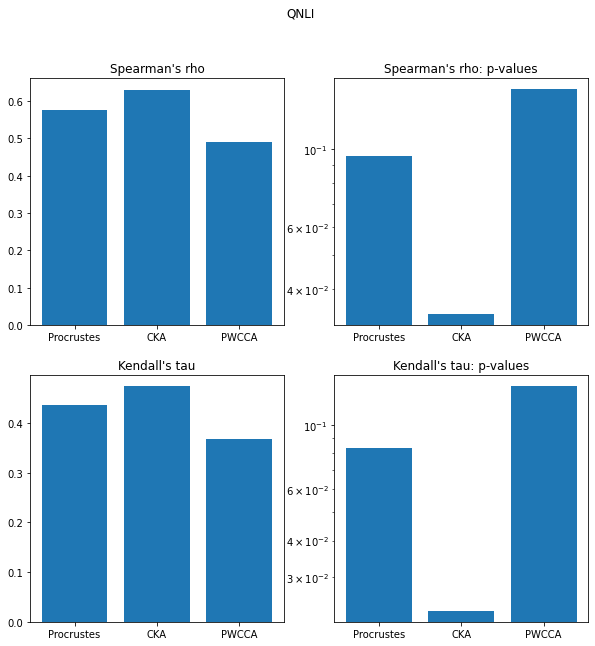

In [29]:
plot_rank_corrs(rho, rho_p, tau, tau_p, METRICS, title = task)

In [30]:
avg_rho = {metric: round(np.mean(rho[metric]), 3) for metric in METRICS}
avg_rho_p = {metric: round(np.mean(rho_p[metric]), 3) for metric in METRICS}
avg_tau = {metric: round(np.mean(tau[metric]), 3) for metric in METRICS}
avg_tau_p = {metric: round(np.mean(tau_p[metric]), 3) for metric in METRICS}

for metric in METRICS:
    ic("\n")
    ic(metric)
    ic(avg_rho[metric])
    ic(avg_rho_p[metric])
    ic(avg_tau[metric])
    ic(avg_tau_p[metric])

ic| "\n": '
           '
ic| metric: 'Procrustes'
ic| avg_rho[metric]: 0.574
ic| avg_rho_p[metric]: 0.096
ic| avg_tau[metric]: 0.435
ic| avg_tau_p[metric]: 0.084
ic| "\n": '
           '
ic| metric: 'CKA'
ic| avg_rho[metric]: 0.628
ic| avg_rho_p[metric]: 0.034
ic| avg_tau[metric]: 0.473
ic| avg_tau_p[metric]: 0.023
ic| "\n": '
           '
ic| metric: 'PWCCA'
ic| avg_rho[metric]: 0.491
ic| avg_rho_p[metric]: 0.148
ic| avg_tau[metric]: 0.368
ic| avg_tau_p[metric]: 0.136
